In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import gc
import pdet
import fpfs
import fitsio
import pltutil
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib.pylab as plt

ver='try4'
gver='basic2'
dver='cut16'
#dver='det'
wrkDir=os.environ['homeWrk']
simDir=os.path.join(wrkDir,'FPFS2/sim/')
def truncSine_func(x,mu=0.,sigma=1.5,deriv=0):
    t=(x-mu)/sigma
    if deriv==0:
        return np.piecewise(t, [t<-1,(t>=-1)&(t<=1),t>1], [0.,lambda t:1./2.+np.sin(t*np.pi/2.)/2., 1.])
    elif deriv==1:
        # multiplicative factor for the first derivative
        return np.piecewise(t, [t<-1+0.01,(t>=-1+0.01)&(t<=1-0.01),t>1-0.01],[0.,lambda t: np.pi/2./sigma*np.cos(t*np.pi/2.)/(1.+np.sin(t*np.pi/2.)), 0.] )


def sigmoid_func(x,mu=0.,sigma=1.5,deriv=0):
    expx=np.exp(-(x-mu)/sigma)
    if deriv==0:
        # sigmoid function
        return 1./(1. + expx)
    elif deriv==1:
        # multiplicative factor for the first derivative
        return 1./sigma*expx/(1. + expx)

def get_detbias(dets,ells,w_sel,icut,isig,ind):
    """
    Args:
        dets:       detection array
        ells:       ellipticity array
        w_sel:      selection weight
        icut:       selection cut
        isig:       sigma of sigmoid function
        inds:       pixel index

    Returns:
        cor1:       correction for shear1
        cor2:       correction for shear2
    """
    fnmv   =  'pdet_v%d%d'  %ind
    fnmr1  =  'fpfs_e1v%d%dr1'%ind
    fnmr2  =  'fpfs_e2v%d%dr2'%ind
    if use_sig:
        wselb  =  sigmoid_func(dets[fnmv],mu=icut,sigma=isig,deriv=1)
    else:
        wselb  =  truncSine_func(dets[fnmv],mu=icut,sigma=isig,deriv=1)
    out1=np.sum(ells[fnmr1]*wselb*w_sel)
    out2=np.sum(ells[fnmr2]*wselb*w_sel)
    return out1,out2

def get_detbias_list(dets,ells,w_sel,indsl,cutsl,bcutl):
    """
    get detection bias due to lower boundar cuts
    Args:
        dets:       ndarray
                    detection array
        ells:       ndarray
                    ellipticity array
        w_sel:      ndarray
                    selection weight
        indsl:      list
                    a list of pixel index
        cutsl:      list
                    a list of selection cuts (sigmoid mu)
        bcutl:      list
                    a list of width of sigmoid functions
    """
    ncut = len(indsl) # assert
    assert len(cutsl)==ncut, 'number of cuts does not match'
    assert len(bcutl)==ncut, 'number of boundary bin size does not match'

    cor1Sum=0.  # initialize the correction terms
    cor2Sum=0.
    for _ in range(ncut):
        fnmv =  'pdet_v%d%d' %indsl[_]
        bcut  =  bcutl[_]
        icut  =  cutsl[_]
        print('apply cut on %s at %.3f' %(fnmv,icut))
        c1,c2=get_detbias(dets,ells,w_sel,icut,bcut,indsl[_])
        cor1Sum+=c1
        cor2Sum+=c2
    return cor1Sum,cor2Sum

def get_selbias(cut,rev,w_sel,icut,isig):
    """
    Args:
        dets:       detection array
        w_sel:      selection weight
        icut:       selection cut
        isig:       sigma of sigmoid function

    Returns:
        cor1:       correction for shear1
        cor2:       correction for shear2
    """
    if use_sig:
        wselb  =  sigmoid_func(cut,mu=icut,sigma=isig,deriv=1)
    else:
        wselb  =  truncSine_func(cut,mu=icut,sigma=isig,deriv=1)
    out1=np.sum(rev*wselb*w_sel)
    out2=np.sum(rev*wselb*w_sel)
    return out1,out2

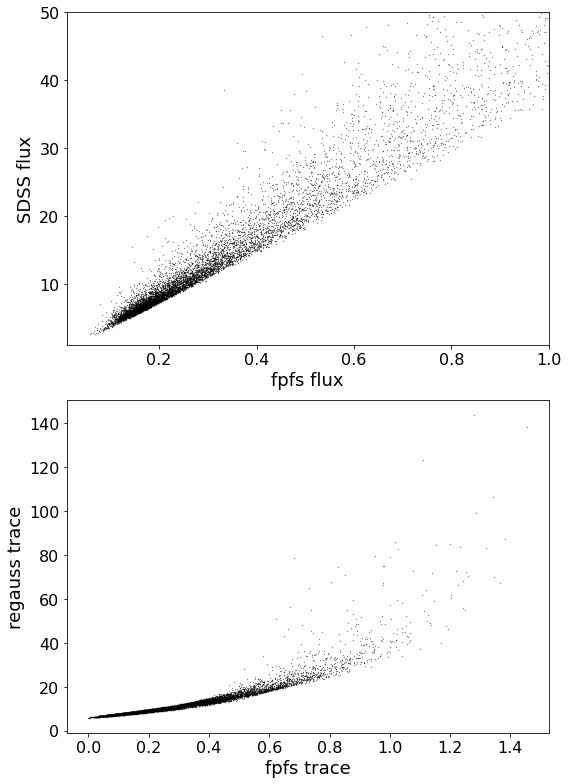

In [56]:
nver='var1em9' # 'var0em0'#
hdat=fitsio.read(os.path.join(simDir,'srcfs2_%sCenter-%s_%s/psf60/src-0000-g1-0000.fits' %(gver,nver,ver)))
fdat=fitsio.read(os.path.join(simDir,'srcfs2_%sCenter-%s_%s/psf60/fpfs-%s-0000-g1-0000.fits' %(gver,nver,ver,dver)))
hdat=hdat[hdat['parent']==0]
ipos1=np.int_((hdat['base_NaiveCentroid_y']//64*100)+hdat['base_NaiveCentroid_x']//64)
ipos2=np.int_((fdat['pdet_y']//64*100)+fdat['pdet_x']//64)
assert np.all(ipos2==np.arange(10000))
fdat=fdat[ipos1]


Const  =   0.
edat=fpfs.fpfsBase.fpfsM2E(fdat,dets=None,const=Const,noirev=False)

fig,axes=pltutil.make_figure_axes(ny=2,nx=1)

ax=axes[0]
ax.scatter(fdat['fpfs_M00']/32.**2.,hdat['base_SdssShape_instFlux'],s=0.04,color='black')
ax.set_xlabel('fpfs flux')
ax.set_ylabel('SDSS flux')
ax.set_xlim(0.01,1)
ax.set_ylim(1,50)

ax=axes[1]
ax.scatter(edat['fpfs_s0']-edat['fpfs_s2'],hdat['ext_shapeHSM_HsmSourceMoments_xx']+hdat['ext_shapeHSM_HsmSourceMoments_yy'],s=0.04,color='black')
#ax.scatter(fdat['fpfs_M00']-fdat['fpfs_M20'],hdat['ext_shapeHSM_HsmSourceMoments_xx']+hdat['ext_shapeHSM_HsmSourceMoments_yy'],s=0.04,color='black')
ax.set_xlabel('fpfs trace')
ax.set_ylabel('regauss trace')
plt.tight_layout()

In [8]:
#nver='var1em9' # 'var0em0'#
nver='var4em3' # 'var0em0'#
#nver='var0em0' # 'var0em0'#
# read noiseless data
outNN1=[]
outNN2=[]
for _i in range(400):
    _a1=fitsio.read(os.path.join(simDir,'srcfs2_%sCenter-%s_%s/psf60/fpfs-%s-%04d-g1-0000.fits' %(gver,nver,ver,dver,_i)))
    _a2=fitsio.read(os.path.join(simDir,'srcfs2_%sCenter-%s_%s/psf60/fpfs-%s-%04d-g1-2222.fits' %(gver,nver,ver,dver,_i)))
    outNN1.append(_a1)
    outNN2.append(_a2)
    del _a1,_a2#,msk1,msk2
outNN1 =   rfn.stack_arrays(outNN1,usemask=False)
outNN2 =   rfn.stack_arrays(outNN2,usemask=False)
detM1=   pdet.peak2det(outNN1)
detM2=   pdet.peak2det(outNN2)

In [88]:
Const  =   50
noirev =   True
ellM1  =   fpfs.fpfsBase.fpfsM2E(outNN1,dets=detM1,const=Const,noirev=noirev)
ellM2  =   fpfs.fpfsBase.fpfsM2E(outNN2,dets=detM2,const=Const,noirev=noirev)
gc.collect()

0

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 6.00000e+00,
        2.80000e+01, 5.70000e+01, 1.90000e+02, 5.24000e+02, 1.38800e+03,
        3.14600e+03, 6.67800e+03, 1.33630e+04, 2.38370e+04, 4.02210e+04,
        6.20850e+04, 8.74870e+04, 1.16069e+05, 1.43171e+05, 1.65595e+05,
        1.80736e+05, 1.88233e+05, 1.86051e+05, 1.77342e+05, 1.63714e+05,
        1.49278e+05, 1.33167e+05, 1.18279e+05, 1.05407e+05, 9.42040e+04,
        8.36270e+04, 7.52290e+04, 6.80130e+04, 6.14770e+04, 5.61820e+04,
        5.14620e+04, 4.69430e+04, 4.32510e+04, 4.01060e+04, 3.76610e+04,
        3.47540e+04, 3.28680e+04, 3.04070e+04, 2.87160e+04, 2.66590e+04,
        2.55620e+04, 2.41000e+04, 2.26150e+04, 2.16230e+04, 2.07610e+04,
        1.95070e+04, 1.87590e+04, 1.79830e+04, 1.72810e+04, 1.65830e+04,
        1.57550e+04, 1.51580e+04, 1.44640e+04, 1.40130e+04, 1.35010e+04,
        1.29020e+04, 1.24610e+04, 1.20920e+04, 1.16510e+04, 1.11590e+04,
        1.11110e+04, 1.06870e+04, 1.01790e+04, 9.83

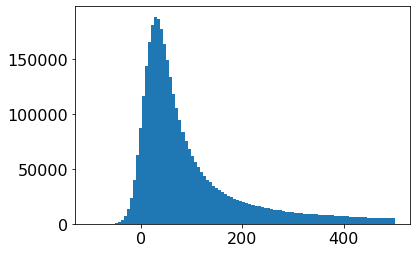

In [83]:
plt.hist(outNN1['fpfs_M00']-outNN1['fpfs_M20'],bins=100,range=(-100,500))

(array([ 2459.,  2957.,  3302.,  3811.,  4195.,  4734.,  5492.,  5997.,
         6859.,  7403.,  8397.,  9421., 10640., 11631., 12985., 14038.,
        15641., 16816., 18511., 19975., 22059., 23890., 25927., 28028.,
        29716., 31567., 33458., 35791., 38119., 40148., 42205., 44304.,
        45929., 47774., 49817., 51824., 53092., 54347., 55715., 56502.,
        57314., 57797., 58694., 58886., 58920., 58721., 58219., 58271.,
        57929., 57311., 56664., 56308., 55370., 54060., 52742., 52091.,
        51112., 50116., 49002., 48043., 46833., 45694., 44603., 43632.,
        42932., 42160., 41022., 40083., 39312., 38603., 37120., 36172.,
        35623., 34527., 33563., 32308., 32021., 30976., 29977., 29689.,
        28951., 28159., 27107., 26310., 25692., 25134., 24308., 23754.,
        23307., 22233., 21855., 21629., 21103., 20546., 20095., 19612.,
        18860., 18411., 17766., 17818.]),
 array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055

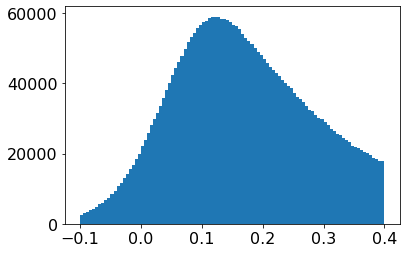

In [84]:
plt.hist(ellM1['fpfs_s0']-ellM1['fpfs_s2'],bins=100,range=(-0.1,0.4))

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 5.00000e+00, 1.80000e+01, 3.10000e+01,
        5.20000e+01, 8.50000e+01, 2.10000e+02, 3.72000e+02, 6.73000e+02,
        1.26400e+03, 2.03900e+03, 3.29800e+03, 5.20500e+03, 7.85000e+03,
        1.15810e+04, 1.64990e+04, 2.26870e+04, 3.08720e+04, 4.05050e+04,
        5.16710e+04, 6.41290e+04, 7.59830e+04, 8.72070e+04, 9.56490e+04,
        1.01206e+05, 1.03424e+05, 1.03328e+05, 1.01482e+05, 9.78230e+04,
        9.32680e+04, 8.87750e+04, 8.46110e+04, 8.10230e+04, 7.70100e+04,
        7.33960e+04, 7.04140e+04, 6.73980e+04, 6.47500e+04, 6.19470e+04,
        5.92790e+04, 5.60780e+04, 5.39060e+04, 5.17570e+04, 4.93910e+04,
        4.75010e+04, 4.57830e+04, 4.34460e+04, 4.23

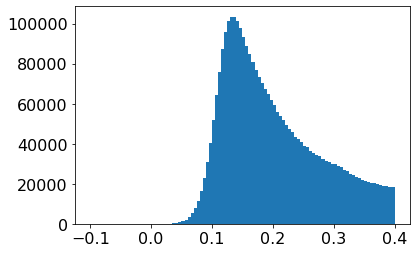

In [80]:
plt.hist(ellM1['fpfs_s0'],bins=100,range=(-0.1,0.4))

0.0
0.06
0.12
0.18
0.24
0.3
0.36
0.42


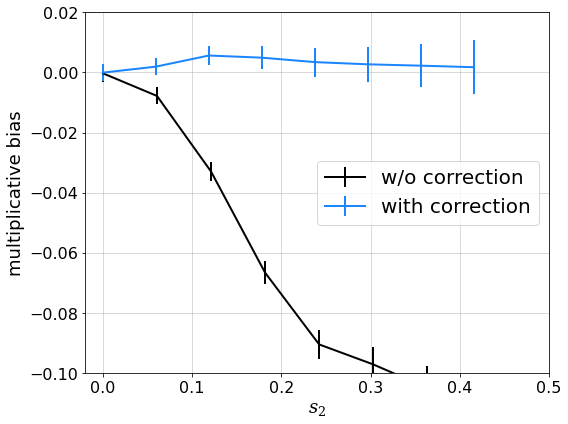

In [81]:
use_sig=False
x=[]
y1=[]
y2=[]
yerr=[]


plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
    
xlabel='$s_2$'
ax.set_xlim(-0.02,0.5)
selnm='fpfs_s2'
cornm='fpfs_RS2'

dcc=0.06 # delta cut
cutB=0.00 # 
cutsig=0.05
    
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    
    # weight array
    ws1 = np.ones(len(detM1))
    if use_sig:
        _wtmp= sigmoid_func(ellM1[selnm],mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(ellM1[selnm],mu=cut,sigma=cutsig)
    ws1=ws1*_wtmp
        
    # weight array
    ws2 = np.ones(len(detM2))
    if use_sig:
        _wtmp= sigmoid_func(ellM2[selnm],mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(ellM2[selnm],mu=cut,sigma=cutsig)
    ws2=ws2*_wtmp

    cor1,cor1b = get_selbias(ellM1[selnm],ellM1[cornm],ws1,cut,cutsig)
    cor2,cor2b = get_selbias(ellM2[selnm],ellM2[cornm],ws2,cut,cutsig)
    de   = np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
gc.collect()

ax.errorbar(np.array(x)*1.01,np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)/1.01,np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel)
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.10,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

0.0
0.06
0.12
0.18
0.24
0.3
0.36
0.42


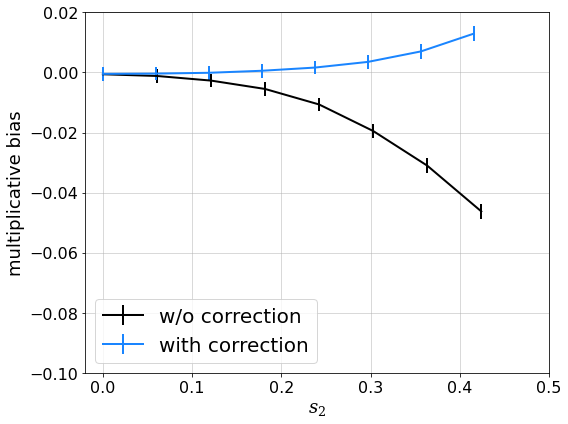

In [89]:
use_sig=False
x=[]
y1=[]
y2=[]
yerr=[]


plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
    
xlabel='$s_2$'
ax.set_xlim(-0.02,0.5)
selnm='fpfs_s2'
cornm='fpfs_RS2'

dcc=0.06 # delta cut
cutB=0.00 # 
cutsig=0.05
    
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    
    # weight array
    ws1 = np.ones(len(detM1))
    if use_sig:
        _wtmp= sigmoid_func(ellM1[selnm],mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(ellM1[selnm],mu=cut,sigma=cutsig)
    ws1=ws1*_wtmp
        
    # weight array
    ws2 = np.ones(len(detM2))
    if use_sig:
        _wtmp= sigmoid_func(ellM2[selnm],mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(ellM2[selnm],mu=cut,sigma=cutsig)
    ws2=ws2*_wtmp

    cor1,cor1b = get_selbias(ellM1[selnm],ellM1[cornm],ws1,cut,cutsig)
    cor2,cor2b = get_selbias(ellM2[selnm],ellM2[cornm],ws2,cut,cutsig)
    de   = np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
gc.collect()

ax.errorbar(np.array(x)*1.01,np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)/1.01,np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel)
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.10,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

0.0
0.06
0.12
0.18
0.24
0.3
0.36
0.42


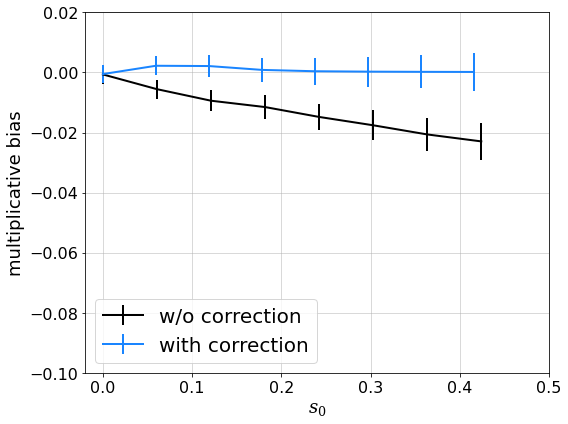

In [69]:
use_sig=False
x=[]
y1=[]
y2=[]
yerr=[]


plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
    
xlabel='$s_0$'
ax.set_xlim(-0.02,0.5)
selnm='fpfs_s0'
cornm='fpfs_RS0'

dcc=0.06 # delta cut
cutB=0.00 # 
cutsig=0.05
    
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    
    # weight array
    ws1 = np.ones(len(detM1))
    if use_sig:
        _wtmp= sigmoid_func(ellM1[selnm],mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(ellM1[selnm],mu=cut,sigma=cutsig)
    ws1=ws1*_wtmp
        
    # weight array
    ws2 = np.ones(len(detM2))
    if use_sig:
        _wtmp= sigmoid_func(ellM2[selnm],mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(ellM2[selnm],mu=cut,sigma=cutsig)
    ws2=ws2*_wtmp

    cor1,cor1b = get_selbias(ellM1[selnm],ellM1[cornm],ws1,cut,cutsig)
    cor2,cor2b = get_selbias(ellM2[selnm],ellM2[cornm],ws2,cut,cutsig)
    de   = np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
gc.collect()

ax.errorbar(np.array(x)*1.01,np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)/1.01,np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel)
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.10,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

0.0
0.06
0.12
0.18
0.24
0.3
0.36
0.42


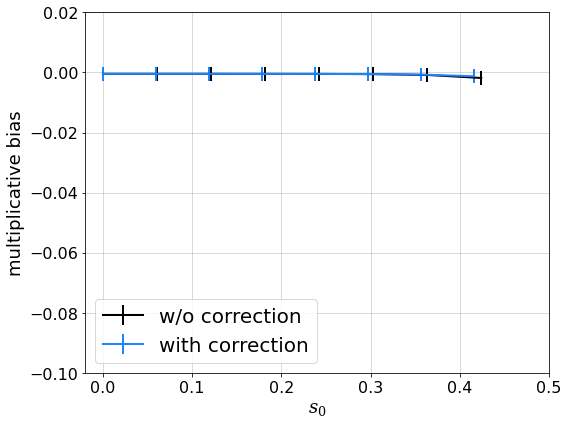

In [86]:
use_sig=False
x=[]
y1=[]
y2=[]
yerr=[]


plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
    
xlabel='$s_0$'
ax.set_xlim(-0.02,0.5)
selnm='fpfs_s0'
cornm='fpfs_RS0'

dcc=0.06 # delta cut
cutB=0.00 # 
cutsig=0.05
    
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    
    # weight array
    ws1 = np.ones(len(detM1))
    if use_sig:
        _wtmp= sigmoid_func(ellM1[selnm],mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(ellM1[selnm],mu=cut,sigma=cutsig)
    ws1=ws1*_wtmp
        
    # weight array
    ws2 = np.ones(len(detM2))
    if use_sig:
        _wtmp= sigmoid_func(ellM2[selnm],mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(ellM2[selnm],mu=cut,sigma=cutsig)
    ws2=ws2*_wtmp

    cor1,cor1b = get_selbias(ellM1[selnm],ellM1[cornm],ws1,cut,cutsig)
    cor2,cor2b = get_selbias(ellM2[selnm],ellM2[cornm],ws2,cut,cutsig)
    de   = np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
gc.collect()

ax.errorbar(np.array(x)*1.01,np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)/1.01,np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel)
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.10,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

-0.1
-0.04000000000000001
0.01999999999999999
0.07999999999999999
0.13999999999999999
0.19999999999999998
0.26
0.31999999999999995


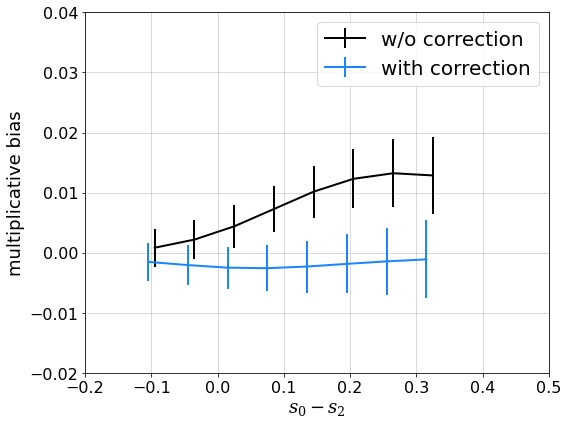

In [70]:
use_sig=True
x=[]
y1=[]
y2=[]
yerr=[]


plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
    
xlabel='$s_0-s_2$'
ax.set_xlim(-0.2,0.5)

dcc=0.06 # delta cut
cutB=-0.1 # 
cutsig=0.08
    
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    
    sel1=ellM1['fpfs_s0']-ellM1['fpfs_s2']
    sel2=ellM2['fpfs_s0']-ellM2['fpfs_s2']
    selrv1=ellM1['fpfs_RS0']-ellM1['fpfs_RS2']
    selrv2=ellM2['fpfs_RS0']-ellM2['fpfs_RS2']
    
    # weight array
    ws1 = np.ones(len(detM1))
    if use_sig:
        _wtmp= sigmoid_func(sel1,mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(sel1,mu=cut,sigma=cutsig)
    ws1=ws1*_wtmp
        
    # weight array
    ws2 = np.ones(len(detM2))
    if use_sig:
        _wtmp= sigmoid_func(sel2,mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(sel2,mu=cut,sigma=cutsig)
    ws2=ws2*_wtmp

    cor1,cor1b = get_selbias(sel1,selrv1,ws1,cut,cutsig)
    cor2,cor2b = get_selbias(sel2,selrv2,ws2,cut,cutsig)
    de   = np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
gc.collect()

ax.errorbar(np.array(x)+0.005,np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)-0.005,np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel)
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.02,0.04)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

-0.2
-0.14
-0.08000000000000002
-0.020000000000000018
0.03999999999999998
0.09999999999999998
0.15999999999999998
0.21999999999999997


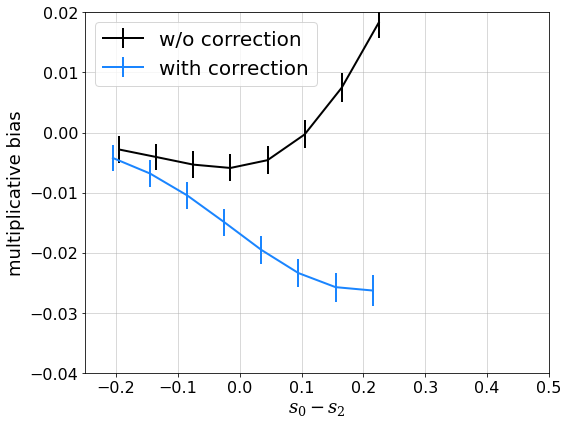

In [91]:
use_sig=True
x=[]
y1=[]
y2=[]
yerr=[]


plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
    
xlabel='$s_0-s_2$'
ax.set_xlim(-0.25,0.5)

dcc=0.06 # delta cut
cutB=-0.2 # 
cutsig=0.08
    
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    
    sel1=ellM1['fpfs_s0']-ellM1['fpfs_s2']
    sel2=ellM2['fpfs_s0']-ellM2['fpfs_s2']
    selrv1=ellM1['fpfs_RS0']-ellM1['fpfs_RS2']
    selrv2=ellM2['fpfs_RS0']-ellM2['fpfs_RS2']
    
    # weight array
    ws1 = np.ones(len(detM1))
    if use_sig:
        _wtmp= sigmoid_func(sel1,mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(sel1,mu=cut,sigma=cutsig)
    ws1=ws1*_wtmp
        
    # weight array
    ws2 = np.ones(len(detM2))
    if use_sig:
        _wtmp= sigmoid_func(sel2,mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(sel2,mu=cut,sigma=cutsig)
    ws2=ws2*_wtmp

    cor1,cor1b = get_selbias(sel1,selrv1,ws1,cut,cutsig)
    cor2,cor2b = get_selbias(sel2,selrv2,ws2,cut,cutsig)
    de   = np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
gc.collect()

ax.errorbar(np.array(x)+0.005,np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)-0.005,np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel)
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.04,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)